### Flipkart Grid Problem Statement 2 : Personalized Recommedation System ###

In [1]:
!pip install wordcloud -q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\bhart\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [73]:
# Load the dataset
df=pd.read_csv('user_Interaction.csv')
df['score']=(df['viewed_count']*4+df['whishlist_count']*6+df['purchased_count']*7)/(df['viewed_count']+df['whishlist_count']+df['purchased_count'])
# df=df.iloc[0:10000,:]
df=df[['user_id','product_id','score']]
print("Shape of the Dataset:",df.shape)
df.head()


Shape of the Dataset: (4000000, 3)


,user_id,product_id,score
0,9788,8621,4.0
1,2669,4384,5.0
2,2469,9823,5.0
3,9044,5462,5.4
4,6501,3999,4.6


In [107]:

df_products=pd.read_csv('products_details.csv')
df_products=df_products.dropna()
df_products=df_products.reset_index()
df_products=df_products.rename(columns={'index':'product_id'})
df_products=df_products.merge(df,on='product_id')


In [108]:
# Calculating the average score
avg_score = np.mean(df_products['score'])
print('Average Score:', avg_score)

Average Score: 4.882996000265038


# Data Preprocessing

In [76]:
# Scaling our "rating" column
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df_products['scaled_score'] = scaler.fit_transform(df_products[['score']])


In [77]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df_products["user_encoded"] = user_encoder.fit_transform(df_products["user_id"])
num_users = len(user_encoder.classes_)

## Encoding products IDs
product_encoder = LabelEncoder()
df_products["product_encoded"] = product_encoder.fit_transform(df_products["product_id"])
num_products = len(product_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique products: {}".format(num_users, num_products))
print("Minimum score: {}, Maximum score: {}".format(min(df_products['score']), max(df_products['score'])))

Number of unique users: 10000, Number of unique products: 8730
Minimum score: 4.0, Maximum score: 5.8


# Model training (collaborative filtering)

In [78]:
# Shuffle the dataset
df_products = shuffle(df_products, random_state=100)

# Create feature matrix X and target variable y
X = df_products[['user_encoded', 'product_encoded']].values
y = df_products["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (2909919, 2)
Shape of y: (2909919,)


In [79]:
test_set_size = .2  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=42)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 2327935
Number of samples in the test set: 581984


In [80]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [81]:
# # Setting TPU_INIT flag
USE_TPU = False # We're not using Kaggle notbook now 

# Checking if TPU is initialized
if USE_TPU:
    # If tpu is connected then start creating TPUStrategy
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
else:
    !nvidia-smi
    
# Print the TensorFlow version
tf_version = tf.__version__
print(f"TensorFlow version: {tf_version}")

Thu Aug 17 17:36:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.91       Driver Version: 516.91       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0    13W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [82]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Product input layer and embedding layer
    product = Input(name='product_encoded', shape=[1])
    product_embedding = Embedding(name='product_embedding', input_dim=num_products, output_dim=embedding_size)(product)
    
    # Dot product of user and Product embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, product_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, product], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    
    return model
# Checking if TPU is initialized and create the model accordingly
if USE_TPU:
    with tpu_strategy.scope():
        model = RecommenderNet(num_users, num_products)
else:
    model = RecommenderNet(num_users, num_products)

# Printing my model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_encoded (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 product_encoded (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 user_embedding (Embedding)  (None, 1, 128)               1280000   ['user_encoded[0][0]']        
                                                                                                  
 product_embedding (Embeddi  (None, 1, 128)               1117440   ['product_encoded[0][0]'

In [83]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Adjust the maximum learning rate and batch size if using TPU
if USE_TPU:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [84]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=5,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/5
233/233 [==============================] - 21s 85ms/step - loss: 0.6931 - mae: 0.2176 - mse: 0.0736 - val_loss: 0.6931 - val_mae: 0.2169 - val_mse: 0.0732 - lr: 1.0000e-05
Epoch 2/5
233/233 [==============================] - 19s 83ms/step - loss: 0.6930 - mae: 0.2176 - mse: 0.0736 - val_loss: 0.6930 - val_mae: 0.2169 - val_mse: 0.0731 - lr: 1.8000e-05
Epoch 3/5
233/233 [==============================] - 19s 80ms/step - loss: 0.6930 - mae: 0.2176 - mse: 0.0736 - val_loss: 0.6930 - val_mae: 0.2169 - val_mse: 0.0731 - lr: 2.6000e-05
Epoch 4/5
233/233 [==============================] - 20s 87ms/step - loss: 0.6929 - mae: 0.2176 - mse: 0.0735 - val_loss: 0.6930 - val_mae: 0.2169 - val_mse: 0.0731 - lr: 3.4000e-05
Epoch 5/5
233/233 [==============================] - 22s 95ms/step - loss: 0.6926 - mae: 0.2173 - mse: 0.0734 - val_loss: 0.6930 - val_mae: 0.2169 - val_mse: 0.0731 - lr: 4.2000e-05


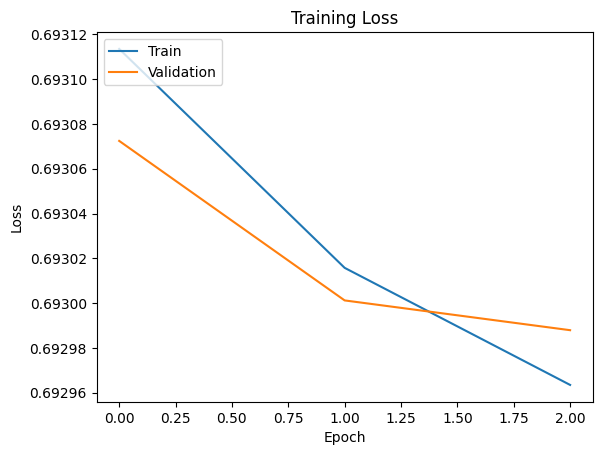

In [85]:
# Training results visualization
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Recommendation:

In [148]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for product embeddings
product_weights = extract_weights('product_embedding', model)
# print(product_weights)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)
# print(user_weights)

#### Reading the whole dataset

### Now we want my model to recommend only those products that have been rated by at least a certain number of users, which we will set as the threshold. This threshold helps ensure that the recommended product titles have received a sufficient number of ratings, indicating a certain level of popularity or user engagement.

In [87]:
# popularity_threshold = 50
# df_products= df_products.query('Members >= @popularity_threshold')
# only give rating of those movies for which atleast 200 user have rated

# 2: User Based Recommendation
#### (The user-based recommendation system is divided into three parts:)

## Part 1: Finding Similar Users
#### In this part, we randomly select a user from the dataset and find similar users based on their product preferences. The find_similar_users function calculates the similarity between users using a weighted matrix and returns a dataframe of similar users. The function takes an input user, number of similar users to find (n), and other optional parameters. The result is a list of similar users to the input user.

In [180]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [182]:
# Select a random user
import random
ratings_per_user = df_products.groupby('user_id').size()
# random_user =random.choice(df['user_id'])
random_user=random.randrange(1,10000);
print(random_user)
# Find similar users to the random user
similar_users = find_similar_users(random_user, n=10, neg=False)
similar_users = similar_users[similar_users.similarity >=.20]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

938


,similar_users,similarity
9,4708,0.328069
8,3787,0.302755
7,4815,0.296200
6,317,0.293234
5,5018,0.290202
4,3827,0.284570
3,8880,0.281476
2,1876,0.277471
1,6356,0.276556
0,9164,0.275603


In [183]:
def clean_and_extract_unique_words(input_string):
    # Remove unwanted characters and split the string into words
    words = input_string.replace('.', ' ').replace("'", "").replace('"', '').replace('[', '').replace(']', '').replace('(', '').replace('&', '').split('>>')

    # Convert words to lowercase and create a set to store unique words
    unique_words = set(word.lower() for word in words)

    return list(unique_words)

input_string = df_products['product_category_tree'][1]
unique_words = clean_and_extract_unique_words(input_string)

print(unique_words)
df_products['product_category_tree']=df_products['product_category_tree'].apply(clean_and_extract_unique_words)
df_products['product_category_tree'][0]


AttributeError: 'list' object has no attribute 'replace'

In [184]:
df_products

,product_id,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,user_id,score
0,1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[ living room furniture , furniture , fabhome...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",2680,5.333333
1,1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[ living room furniture , furniture , fabhome...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",7651,4.750000
2,1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[ living room furniture , furniture , fabhome...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",5621,4.750000
3,1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[ living room furniture , furniture , fabhome...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",4286,5.500000
4,1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[ living room furniture , furniture , fabhome...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",313,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909914,11999,edc21c7ae3c5181a678c45ba4ac2aba9,2015-12-30 00:17:46 +0000,http://www.flipkart.com/cottinfab-women-s-chec...,Cottinfab Women's Checkered Casual Shirt,"[ cottinfab shirts, womens clothing , clothin...",SHTDZZHVJJJDEHQS,899.0,299.0,"[""http://img6a.flixcart.com/image/shirt/h/q/s/...",False,Cottinfab Women's Checkered Casual Shirt - Buy...,4.5,4.5,Regular Fit,"{""product_specification""=>[{""key""=>""Pattern"", ...",6414,4.500000
2909915,11999,edc21c7ae3c5181a678c45ba4ac2aba9,2015-12-30 00:17:46 +0000,http://www.flipkart.com/cottinfab-women-s-chec...,Cottinfab Women's Checkered Casual Shirt,"[ cottinfab shirts, womens clothing , clothin...",SHTDZZHVJJJDEHQS,899.0,299.0,"[""http://img6a.flixcart.com/image/shirt/h/q/s/...",False,Cottinfab Women's Checkered Casual Shirt - Buy...,4.5,4.5,Regular Fit,"{""product_specification""=>[{""key""=>""Pattern"", ...",4422,4.800000
2909916,11999,edc21c7ae3c5181a678c45ba4ac2aba9,2015-12-30 00:17:46 +0000,http://www.flipkart.com/cottinfab-women-s-chec...,Cottinfab Women's Checkered Casual Shirt,"[ cottinfab shirts, womens clothing , clothin...",SHTDZZHVJJJDEHQS,899.0,299.0,"[""http://img6a.flixcart.com/image/shirt/h/q/s/...",False,Cottinfab Women's Checkered Casual Shirt - Buy...,4.5,4.5,Regular Fit,"{""product_specification""=>[{""key""=>""Pattern"", ...",345,5.000000
2909917,11999,edc21c7ae3c5181

In [185]:
df_products.head(2)

,product_id,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,user_id,score
0,1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[ living room furniture , furniture , fabhome...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",2680,5.333333
1,1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[ living room furniture , furniture , fabhome...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",7651,4.750000


## Part 2: User Preferences
#### This part focuses on understanding the preferences of the selected user. The get_user_preferences function takes a user ID as input and retrieves the anime preferences of that user. It considers the top-rated animes by the user and analyzes the genres they prefer. The function also provides an option to plot a word cloud to visualize the preferred genres. The output is a dataframe containing the anime titles and their associated genres.

In [186]:
# Function to display a word cloud of preferred genres

def showWordCloud(all_categories):
    category_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_categories)
    plt.figure(figsize=(10, 8))
    plt.imshow(category_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [187]:
def get_user_preferences(user_id, plot=False, verbose=0):
    products_viewed_by_user = df_products[df_products['user_id'] == user_id]
    if products_viewed_by_user.empty:
        print("User #{} has not viewed any product.".format(user_id))
        return pd.DataFrame()
    user_rating_percentile = np.percentile(products_viewed_by_user.score, 75)
    products_viewed_by_user = products_viewed_by_user[products_viewed_by_user.score >= 3] 
    top_products_user = (
        products_viewed_by_user.sort_values(by="score", ascending=False)
        .product_id.values
    )
    product_df_rows = df_products[df_products["product_id"].isin(top_products_user)]

    product_df_rows = product_df_rows[["product_name", "product_category_tree"]]

    
    if verbose != 0:
        print("User \033[1m{}\033[0m has viewed {} product(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(products_viewed_by_user), products_viewed_by_user['score'].mean()
        ))
        print('\033[1m----- Preferred categories----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in product_df_rows['product_category_tree']:
                for genre in genres:
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))
    
    return product_df_rows

User 938 has viewed 293 product(s) with an average rating of 4.8/10

----- Preferred categories----- 



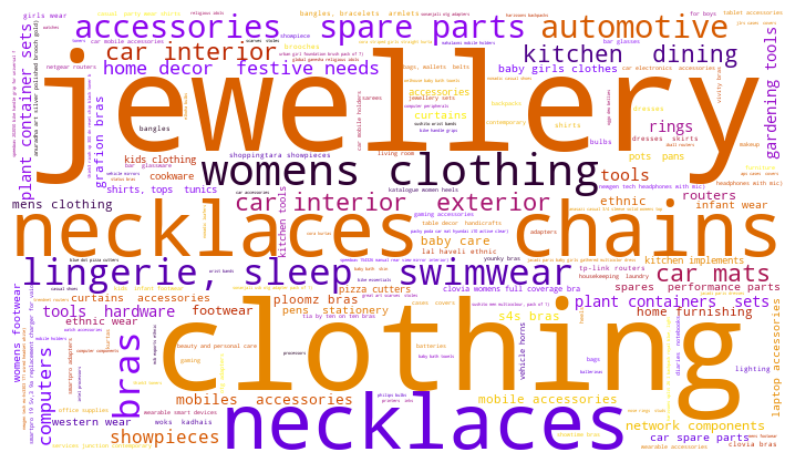

,product_name,product_category_tree
7998,Shopmania Music Band A5 Notebook Spiral Bound,"[pens stationery , diaries notebooks , not..."
7999,Shopmania Music Band A5 Notebook Spiral Bound,"[pens stationery , diaries notebooks , not..."
8000,Shopmania Music Band A5 Notebook Spiral Bound,"[pens stationery , diaries notebooks , not..."
8001,Shopmania Music Band A5 Notebook Spiral Bound,"[pens stationery , diaries notebooks , not..."
8002,Shopmania Music Band A5 Notebook Spiral Bound,"[pens stationery , diaries notebooks , not..."
...,...,...
2891230,My Addiction Women's Self Design Casual Shirt,"[ womens clothing , clothing , my addiction s..."
2891231,My Addiction Women's Self Design Casual Shirt,"[ womens clothing , clothing , my addiction s..."
2891232,My Addiction Women's Self Design Casual Shirt,"[ womens clothing , clothing , my addiction s..."
2891233,My Addiction Women's Self Design Casual Shirt,"[ womens clothing , clothing , my addiction s..."


In [188]:
# Get user preferences for the random user
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
user_pref


## Part 3: Recommending Products for a User
#### In the final part, we recommend Products to the selected user based on the preferences of similar users. The get_recommended_product function iterates through the list of similar users, retrieves their preferences, and identifies product that are not present in the preferences of the selected user. It then generates a list of recommended product along with their category and a brief description. The output is a dataframe containing the recommended products for the user.

In [189]:

def get_recommended_products(similar_users, user_pref, n=10):
    recommended_products = []
    product_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        
        if not pref_list.empty:  # Check if user has viewed product
            pref_list = pref_list[~pref_list["product_name"].isin(user_pref["product_name"].values)]
            product_list.append(pref_list.product_name.values)
       
         
    if len(product_list) == 0:
        print("No product recommendations available for the given users.")
        return pd.DataFrame()
    
    product_list = pd.DataFrame(product_list)
    
    sorted_list = pd.DataFrame(pd.Series(product_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    product_count = df_products['product_id'].value_counts()
    
    for i, product_name in enumerate(sorted_list.index):
        if isinstance(product_name, str):
            try:
                product_id = df_products[df_products.product_name == product_name].product_id.values[0]
                category = df_products[df_products.product_name == product_name].product_category_tree.values[0]
                description = df_products[df_products.product_name == product_name].description.values[0]
                n_user_pref = product_count.get(product_id, 0)  # Get the total count of users who have watched this anime
                recommended_products.append({
                    "n": n_user_pref,
                    "product_name": product_name, 
                    "category": category, 
                    "description": description
                })
            except:
                pass
    return pd.DataFrame(recommended_products)

In [190]:
# Get recommended product for the random user
recommended_products = get_recommended_products(similar_users, user_pref, n=20)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_products



> Top recommendations for user: 938


,n,product_name,category,description
0,359,S4S Comfortable Women's Full Coverage Bra,"[ lingerie, sleep swimwear , womens clothing...",S4S Comfortable Women's Full Coverage Bra\n ...
1,320,Voylla Yellow Gold Plated Alloy Necklace,"[jewellery , necklaces chains , necklaces]",Voylla Yellow Gold Plated Alloy Necklace - Buy...
2,322,Jewelizer Alloy Necklace,"[jewellery , necklaces chains , necklaces]",Jewelizer Alloy Necklace - Buy Jewelizer Alloy...
3,343,Fuson Back Cover for Samsung Galaxy J7,"[ tablet accessories , mobiles accessories , ...",Buy Fuson Back Cover for Samsung Galaxy J7 onl...
4,344,Babeezworld Baby Boy's Romper,"[ dungarees jumpsuits , dungarees , baby car...",Key Features of Babeezworld Baby Boy's Romper ...
5,326,Voylla Alloy Necklace,"[jewellery , necklaces chains , necklaces]",Voylla Alloy Necklace - Buy Voylla Alloy Neckl...
6,306,DeStudio Tiny Wall Sticker,"[ wall decals stickers , home decor festive ...",Buy DeStudio Tiny Wall Sticker for Rs.399 onli...
7,292,i-KitPit Pouch for Lenovo A369i,"[mobiles accessories , mobile accessories , ...",i-KitPit Pouch for Lenovo A369i\n ...
8,347,Joyeria Milan Resin Necklace,"[jewellery , necklaces chains , necklaces]",Joyeria Milan Resin Necklace - Buy Joyeria Mil...
9,321,S4S Women's Full Coverage Bra,"[ lingerie, sleep swimwear , womens clothing...",S4S Women's Full Coverage Bra - Buy Purple S4S...
